## Importing our speech data
Our API will be served directly from our container using Flask, a popular Python Web Server.
The Flask application, which will call our prediction function, is defined in the `wsgi.py` file.

As always, we'll first run some imports to make sure all our requirements are there:

In [1]:
import os
import boto3
import numpy as np
from os import walk

from utils.io import load_config
from datasets.preprocess import load_meta_data
from utils.text.tokenizer import TTSTokenizer
from matplotlib import pylab as plt

import collections
import operator

from configs.glow_tts_config import GlowTTSConfig
from configs.shared_configs import BaseDatasetConfig

import IPython.display as ipd

!pip install unidecode
!pip install phonemizer

In [2]:
# ==============================================================
# Pull AWS access keys from environment variables previously set 
# in Jupyter Hub
# =============================================================
key_id          = os.environ.get('AWS_ACCESS_KEY_ID')
secret_key      = os.environ.get('AWS_SECRET_ACCESS_KEY')

session         = boto3.session.Session(aws_access_key_id=key_id, aws_secret_access_key=secret_key)

s3_client       = boto3.client('s3',
                  aws_access_key_id=key_id,
                  aws_secret_access_key=secret_key)

In [3]:
# ==============================================================
# Download jobs file from S3 and place it into a folder
#===============================================================
bucket_name     = 'rhods-pilot'
s3_folder       = 'LJSpeech-1.1'
local_dest_dir  = os.path.join(os.getcwd(), 'datasets/LJSpeech-1.1')
s3 = boto3.resource('s3')

In [4]:

def download_s3_folder(bucket_name, s3_folder, local_dir=None):
    """
    Download the contents of a folder directory
    Args:
        bucket_name: the name of the s3 bucket
        s3_folder: the folder path in the s3 bucket
        local_dir: a relative or absolute directory path in the local file system
    """
    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=s3_folder):
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)


download_s3_folder(bucket_name, s3_folder, local_dest_dir)


In [4]:
output_path = os.path.dirname(os.getcwd())

dataset_config = BaseDatasetConfig(
    name="ljspeech", meta_file_train="metadata.csv", path=os.path.join(output_path, "text-to-speech/datasets/LJSpeech-1.1/")
)

# INITIALIZE THE TRAINING CONFIGURATION
# Configure the model. Every config class inherits the BaseTTSConfig.
config = GlowTTSConfig(
    batch_size=16,
    eval_batch_size=8,
    num_loader_workers=4,
    num_eval_loader_workers=4,
    run_eval=True,
    test_delay_epochs=0,
    epochs=1,
    text_cleaner="phoneme_cleaners",
    use_phonemes=True,
    phoneme_language="en-us",
    phoneme_cache_path=os.path.join(output_path, "phoneme_cache"),
    print_step=400,
    print_eval=False,
    mixed_precision=True,
    output_path=output_path,
    datasets=[dataset_config],
)

# Load config.json properties
CONFIG = load_config('config.json')

# Load some properties from config.json
CONFIG_METADATA = sorted(load_meta_data(CONFIG.datasets)[0])
CONFIG_DATASET = CONFIG.datasets[0]
CONFIG_PHONEME_LANGUAGE = CONFIG.phoneme_language
CONFIG_TEXT_CLEANER = CONFIG.text_cleaner
CONFIG_ENABLE_EOS_BOS_CHARS = CONFIG.enable_eos_bos_chars

# Will be printed on generated output graph
CONFIG_RUN_NAME = CONFIG.run_name
CONFIG_RUN_DESC = CONFIG.run_description

 | > Found 13100 files in /opt/app-root/src/text-to-speech/datasets/LJSpeech-1.1


In [5]:
# print some debug information on loaded config values
print(" > Run name: " + CONFIG_RUN_NAME + " (" + CONFIG_RUN_DESC + ")")
print(" > Dataset files: " + str(len(CONFIG_METADATA)))
print(" > Phoneme language: " + CONFIG_PHONEME_LANGUAGE)
print(" > Used text cleaner: " + CONFIG_TEXT_CLEANER)
print(" > Enable eos bos chars: " + str(CONFIG_ENABLE_EOS_BOS_CHARS))

 > Run name: run (🐸Coqui trainer run.)
 > Dataset files: 12969
 > Phoneme language: en-us
 > Used text cleaner: phoneme_cleaners
 > Enable eos bos chars: False


In [6]:
ipd.Audio(filename='datasets/LJSpeech-1.1/wavs/LJ001-0001.wav')

In [7]:
# INITIALIZE THE TOKENIZER
# Tokenizer is used to convert between text and token IDs.
# If characters are not defined in the config, default characters are passed to the config
tokenizer, config = TTSTokenizer.init_from_config(config)

f = []
phonemes = []
for (dirpath, dirnames, filenames) in walk('phoneme_cache'):
    f.extend(filenames)
    break
for filename in f:
    ph = np.load('phoneme_cache/' + filename)
    phonemes.append(tokenizer.ids_to_text(ph))

In [8]:
print('LJ001-0001_phoneme.npy' + ": ")
print(tokenizer.ids_to_text(np.load('phoneme_cache/LJ001-0001_phoneme.npy')))

LJ001-0001_phoneme.npy: 
pɚnt, ən oʊnli sənz wʊ wt wi ɪt pzɑnt kənsnd, dəfz fm məst əf nt fm əl ɚts ʌnd kfts pzɑntd ən ɪksbən


In [9]:
s = ""
phonemeString = s.join(phonemes)

d = {}
collections._count_elements(d, phonemeString)
sorted_d = dict(sorted(d.items(), key=operator.itemgetter(1),reverse=True))

# remove useless keys
sorted_d.pop(' ', None)
sorted_d.pop('ˈ', None)

phonemesSum = len(phonemeString.replace(" ",""))

print("Dataset contains " + str(len(sorted_d)) + " different ipa phonemes.")
print("Dataset consists of " + str(phonemesSum) + " phonemes")

Dataset contains 40 different ipa phonemes.
Dataset consists of 978095 phonemes


In [10]:
print("5 rarest phonemes")

rareList = dict(sorted(sorted_d.items(), key=operator.itemgetter(1), reverse=False)[:5])
for key, value in rareList.items():
    print(key + " --> " + str(value) + " occurrences")

5 rarest phonemes
! --> 46 occurrences
? --> 76 occurrences
j --> 4710 occurrences
θ --> 5020 occurrences
ʒ --> 5440 occurrences


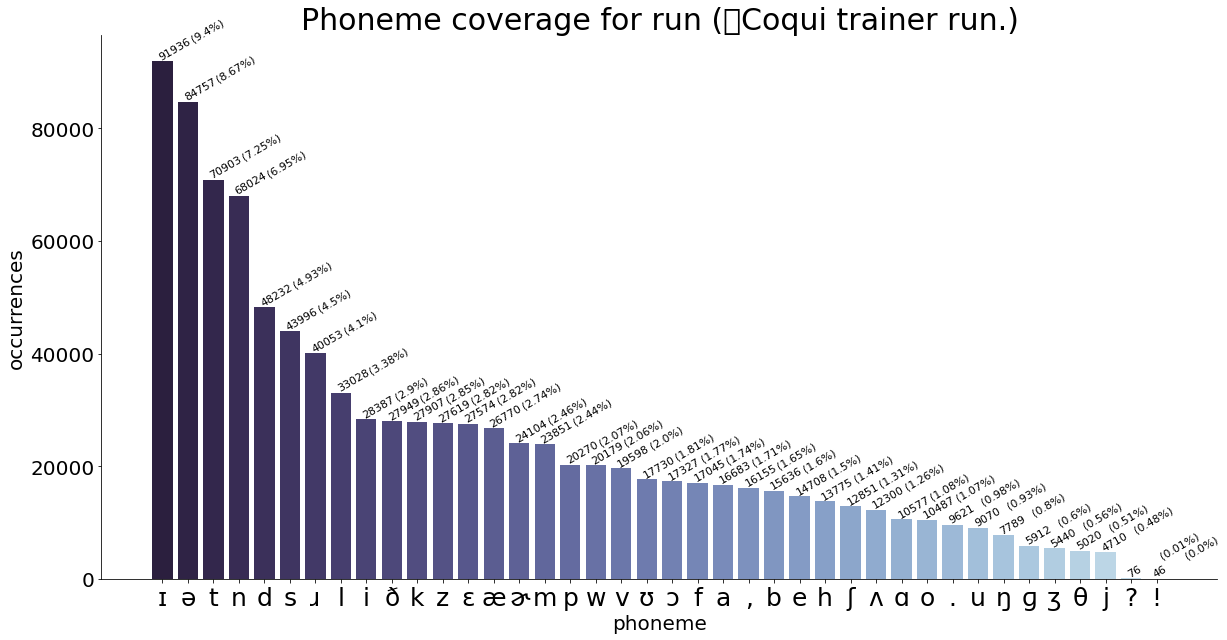

In [12]:
# create plot from analysis result
import seaborn as sns
x = []
y = []

for key, value in sorted_d.items():
    x.append(key)
    y.append(value)
    
pale = sns.color_palette("ch:s=.25,rot=-.25",len(x))[::-1]

plt.figure(figsize=(20,10))
plt.title("Phoneme coverage for " + CONFIG_RUN_NAME + " (" + CONFIG_RUN_DESC + ")", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.bar(x,y, align='center', alpha=1.0, color=pale)
plt.xlabel('phoneme', fontsize=20)
plt.ylabel('occurrences', fontsize=20)
sns.despine()

for i, v in enumerate(y):
    plt.text(i - 0.2, v + 300, str(v), fontsize=11, rotation=30)
    plt.text(i + 1.05, v + 3500, "(" + str(round(100/phonemesSum * v,2)) + "%)", fontsize=11, rotation=30)


plt.show()